# Import Required Libraries

In [6]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Define Dataset Path and Transformations

In [7]:
# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/ViT/DATASET/AUGMENTED_DATASET"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the Dataset

In [8]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


# Splitting the Dataset into Training and Validation Sets 85-15

In [9]:
# Groups of images were prepared using base image identifiers
image_groups = {}
for img_path, _ in dataset.samples:
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])  # Base ID was extracted before augmentation tags
    if original_id not in image_groups:
        image_groups[original_id] = []
    image_groups[original_id].append(img_path)

# Group keys were shuffled to ensure random distribution
random.seed(42)
group_keys = list(image_groups.keys())
random.shuffle(group_keys)

# The dataset was split into training (70%), validation (15%), and test (15%) sets
total = len(group_keys)
train_size = round(0.70 * total)
val_size = round(0.20 * total)
test_size = total - train_size - val_size

train_keys = set(group_keys[:train_size])
val_keys = set(group_keys[train_size:train_size + val_size])
test_keys = set(group_keys[train_size + val_size:])

# Indices were assigned to the appropriate split based on the group identifier
train_indices, val_indices, test_indices = [], [], []

for idx, (img_path, _) in enumerate(dataset.samples):
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])
    if original_id in train_keys:
        train_indices.append(idx)
    elif original_id in val_keys:
        val_indices.append(idx)
    elif original_id in test_keys:
        test_indices.append(idx)

# Subsets were created for each split
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

# Data loaders were initialized for model1training and evaluation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3462
Validation samples: 956
Test samples: 482


# Loading the Swin-Tiny Model

In [10]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim

# Load pretrained Swin-Tiny with appropriate output classes
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.patch_embed.parameters():
    param.requires_grad = True

for param in model.head.parameters():
    param.requires_grad = True

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded and moved to {device}")
print("Only patch embedding (input) and classification head (output) are trainable.")

Model loaded and moved to cpu
Only patch embedding (input) and classification head (output) are trainable.


# Defining Loss Function and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Defining the Training Loop

In [12]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=15):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "swin_tiny_best_model.pth")
            print("Model improved. Best checkpoint saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return history
history1 = train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=15)

Epoch 1/20: 100%|█████████████████████████████| 109/109 [14:17<00:00,  7.87s/it]


Epoch 1/20: Train Loss: 1.3174, Train Acc: 56.44% | Val Loss: 0.8426, Val Acc: 74.37%
Model improved. Best checkpoint saved.


Epoch 2/20: 100%|█████████████████████████████| 109/109 [16:55<00:00,  9.32s/it]


Epoch 2/20: Train Loss: 0.7888, Train Acc: 74.99% | Val Loss: 0.7007, Val Acc: 76.99%
Model improved. Best checkpoint saved.


Epoch 3/20: 100%|█████████████████████████████| 109/109 [13:11<00:00,  7.26s/it]


Epoch 3/20: Train Loss: 0.6212, Train Acc: 80.07% | Val Loss: 0.5614, Val Acc: 80.13%
Model improved. Best checkpoint saved.


Epoch 4/20: 100%|█████████████████████████████| 109/109 [13:28<00:00,  7.42s/it]


Epoch 4/20: Train Loss: 0.5531, Train Acc: 81.72% | Val Loss: 0.4720, Val Acc: 84.62%
Model improved. Best checkpoint saved.


Epoch 5/20: 100%|█████████████████████████████| 109/109 [13:46<00:00,  7.59s/it]


Epoch 5/20: Train Loss: 0.4889, Train Acc: 83.82% | Val Loss: 0.4361, Val Acc: 84.83%
Model improved. Best checkpoint saved.


Epoch 6/20: 100%|█████████████████████████████| 109/109 [13:35<00:00,  7.48s/it]


Epoch 6/20: Train Loss: 0.4677, Train Acc: 84.23% | Val Loss: 0.3773, Val Acc: 85.77%
Model improved. Best checkpoint saved.


Epoch 7/20: 100%|█████████████████████████████| 109/109 [14:14<00:00,  7.84s/it]


Epoch 7/20: Train Loss: 0.4155, Train Acc: 86.42% | Val Loss: 0.4189, Val Acc: 86.72%
No improvement. Early stopping counter: 1/15


Epoch 8/20: 100%|█████████████████████████████| 109/109 [13:21<00:00,  7.35s/it]


Epoch 8/20: Train Loss: 0.3753, Train Acc: 87.95% | Val Loss: 0.3667, Val Acc: 86.92%
Model improved. Best checkpoint saved.


Epoch 9/20: 100%|█████████████████████████████| 109/109 [13:03<00:00,  7.19s/it]


Epoch 9/20: Train Loss: 0.3649, Train Acc: 88.56% | Val Loss: 0.3534, Val Acc: 88.08%
Model improved. Best checkpoint saved.


Epoch 10/20: 100%|████████████████████████████| 109/109 [13:45<00:00,  7.57s/it]


Epoch 10/20: Train Loss: 0.3522, Train Acc: 88.56% | Val Loss: 0.3542, Val Acc: 88.60%
No improvement. Early stopping counter: 1/15


Epoch 11/20: 100%|████████████████████████████| 109/109 [14:05<00:00,  7.76s/it]


Epoch 11/20: Train Loss: 0.3230, Train Acc: 89.98% | Val Loss: 0.3457, Val Acc: 88.18%
Model improved. Best checkpoint saved.


Epoch 12/20: 100%|████████████████████████████| 109/109 [11:41<00:00,  6.43s/it]


Epoch 12/20: Train Loss: 0.3094, Train Acc: 90.01% | Val Loss: 0.3324, Val Acc: 89.12%
Model improved. Best checkpoint saved.


Epoch 13/20: 100%|████████████████████████████| 109/109 [08:45<00:00,  4.82s/it]


Epoch 13/20: Train Loss: 0.2947, Train Acc: 90.61% | Val Loss: 0.3123, Val Acc: 89.64%
Model improved. Best checkpoint saved.


Epoch 14/20: 100%|████████████████████████████| 109/109 [08:41<00:00,  4.78s/it]


Epoch 14/20: Train Loss: 0.2815, Train Acc: 91.02% | Val Loss: 0.3064, Val Acc: 90.06%
Model improved. Best checkpoint saved.


Epoch 15/20: 100%|████████████████████████████| 109/109 [09:25<00:00,  5.19s/it]


Epoch 15/20: Train Loss: 0.2702, Train Acc: 91.28% | Val Loss: 0.2934, Val Acc: 91.21%
Model improved. Best checkpoint saved.


Epoch 16/20: 100%|████████████████████████████| 109/109 [09:32<00:00,  5.25s/it]


Epoch 16/20: Train Loss: 0.2630, Train Acc: 91.97% | Val Loss: 0.2936, Val Acc: 90.38%
No improvement. Early stopping counter: 1/15


Epoch 17/20: 100%|████████████████████████████| 109/109 [09:55<00:00,  5.46s/it]


Epoch 17/20: Train Loss: 0.2629, Train Acc: 92.26% | Val Loss: 0.2889, Val Acc: 91.74%
Model improved. Best checkpoint saved.


Epoch 18/20: 100%|████████████████████████████| 109/109 [08:49<00:00,  4.86s/it]


Epoch 18/20: Train Loss: 0.2556, Train Acc: 92.09% | Val Loss: 0.2822, Val Acc: 90.69%
Model improved. Best checkpoint saved.


Epoch 19/20: 100%|████████████████████████████| 109/109 [08:40<00:00,  4.77s/it]


Epoch 19/20: Train Loss: 0.2377, Train Acc: 93.24% | Val Loss: 0.2829, Val Acc: 91.53%
No improvement. Early stopping counter: 1/15


Epoch 20/20: 100%|████████████████████████████| 109/109 [08:58<00:00,  4.94s/it]


Epoch 20/20: Train Loss: 0.2495, Train Acc: 92.58% | Val Loss: 0.2815, Val Acc: 91.32%
Model improved. Best checkpoint saved.


# Visualizing Training & Validation Performance

In [35]:
import sys

# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_model_artifacts, handle_dataset

In [36]:
def evaluate_model(model, dataloader, class_names=dataset.classes, top_k=(1, 5), loader_name="Validation", model_name="Model"):
    print(f"\n========== Evaluating {model_name} on {loader_name} Set ==========\n")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                top_k_correct[k] += np.sum(labels.cpu().numpy()[:, None] == top_k_preds[:, :k])
            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }

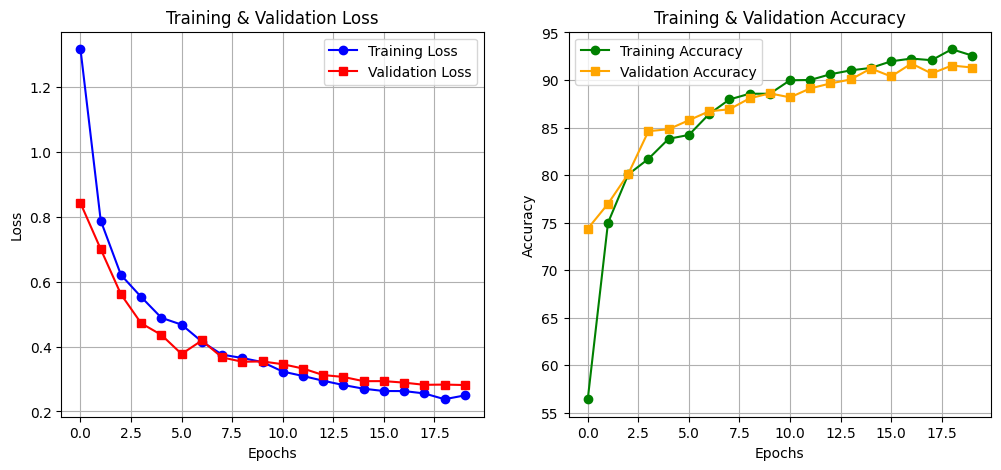


========== Evaluating Swin-tiny V1 on Validation Set ==========


Overall Accuracy: 91.32%
Overall Error Rate: 8.68%
F1-Score (Macro-Averaged): 91.45%
F1-Score (Weighted): 91.32%
Matthews Correlation Coefficient (MCC): 89.86%
Cohen’s Kappa Score: 89.85%
Top-1 Accuracy (%): 91.32%
Top-5 Accuracy (%): 99.79%

Average Inference Time per Image: 0.078873 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          86.39       89.02         87.69            97.10
 BRRI_28          91.94       89.06         90.48            98.79
 BRRI_29          85.82       84.56         85.19            97.68
 BRRI_34          91.61       94.24         92.91            98.53
 BRRI_50          92.62       92.62         92.62            98.92
 BRRI_74          97.08       97.08         97.08            99.51
    BR_5          95.28       93.08         94.16            99.27

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108 

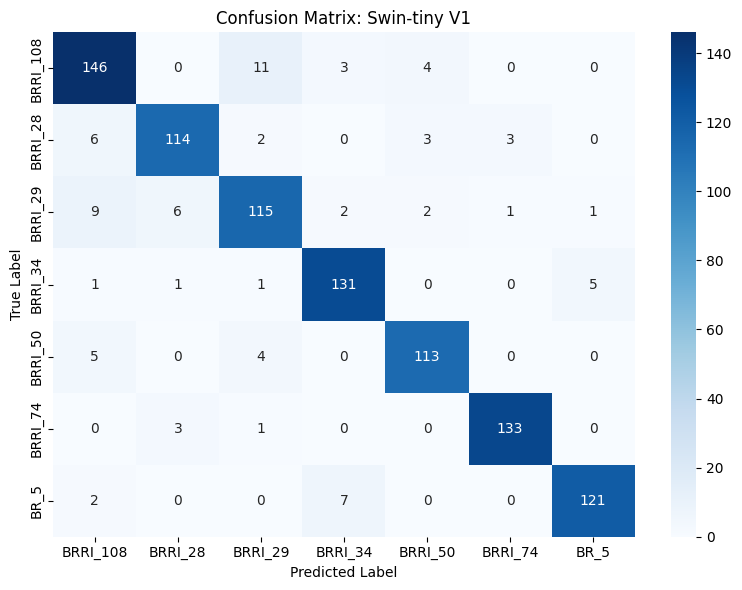

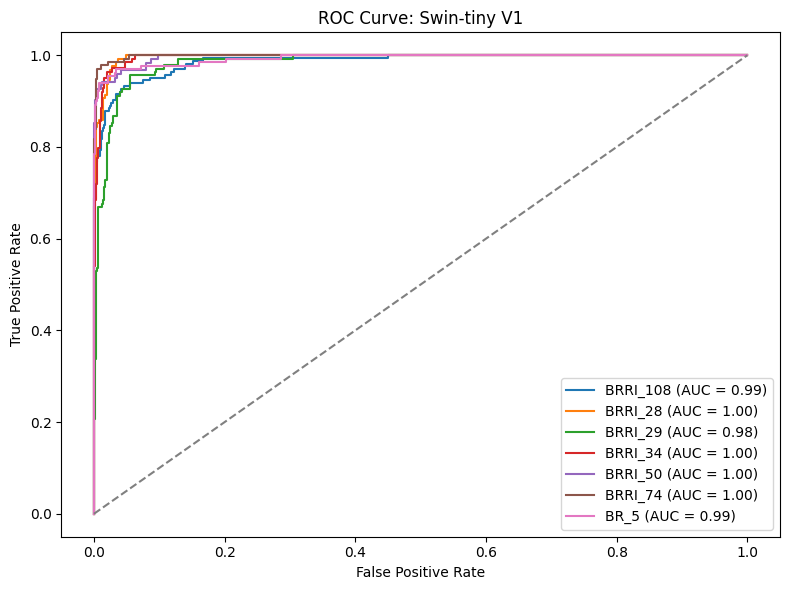

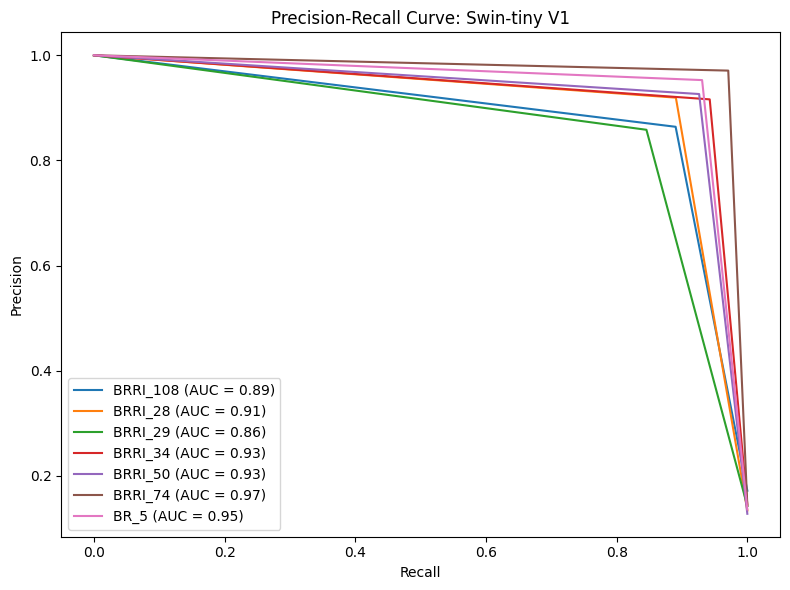


========== Evaluating Swin-tiny V1 on Tesing Set ==========


Overall Accuracy: 89.63%
Overall Error Rate: 10.37%
F1-Score (Macro-Averaged): 89.60%
F1-Score (Weighted): 89.70%
Matthews Correlation Coefficient (MCC): 87.91%
Cohen’s Kappa Score: 87.88%
Top-1 Accuracy (%): 89.63%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.073649 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          81.54       82.81         82.17            97.13
 BRRI_28          96.05       89.02         92.41            99.25
 BRRI_29          79.73       88.06         83.69            96.39
 BRRI_34          86.59       92.21         89.31            97.28
 BRRI_50          98.48       95.59         97.01            99.76
 BRRI_74          92.06       95.08         93.55            98.81
    BR_5          94.64       84.13         89.08            99.28

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108   

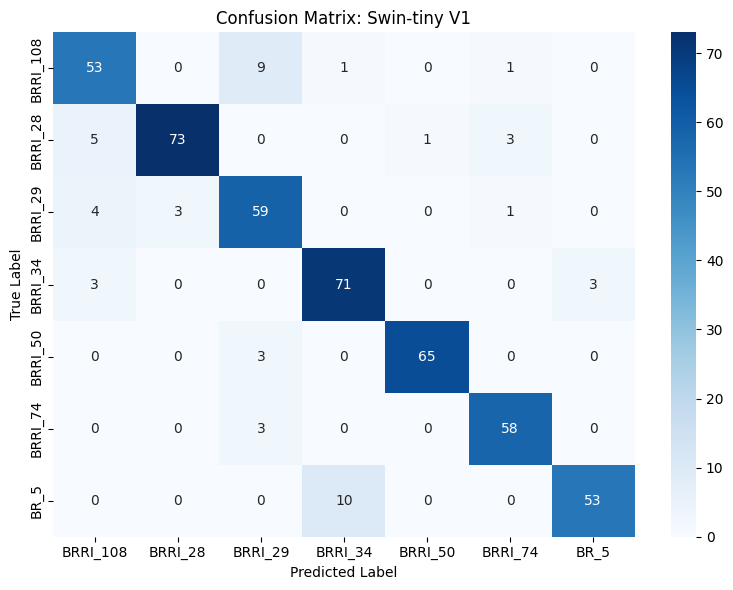

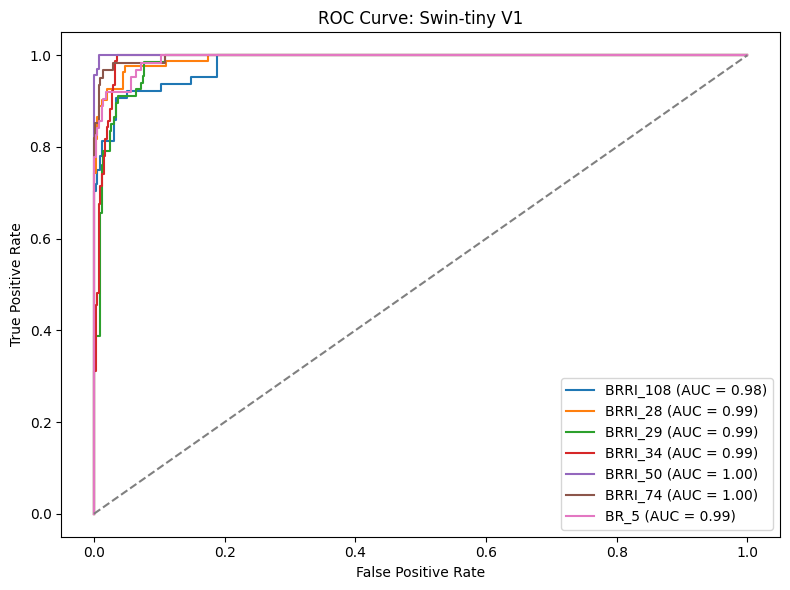

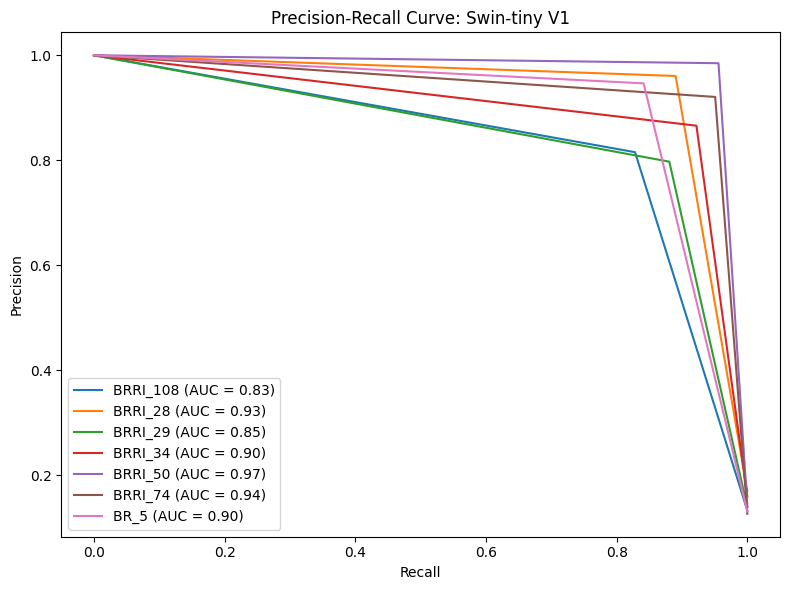

In [37]:
plotting(history1)
metrics1 = evaluate_model(model, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="Swin-tiny V1")
metrics1 = evaluate_model(model, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="Swin-tiny V1")

In [38]:
save_model_artifacts(model=model,history=history1,metrics=metrics1,model_name="Swin_tiny_Final",version="1")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/Swin_tiny_Final_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/Swin_tiny_Final/Swin_tiny_Final_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/Swin_tiny_Final_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/Swin_tiny_Final_class_wise_metrics_1.csv


In [42]:
model2 = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=num_classes)

for param in model2.parameters():
    param.requires_grad = False

for param in model2.patch_embed.parameters():
    param.requires_grad = True
for param in model2.head.parameters():
    param.requires_grad = True

checkpoint_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/Swin_tiny_Final/Swin_tiny_Final_1.pth"
model2.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

print(f"Model reloaded as model2 from: {checkpoint_path}")
print(f"Only patch_embed and head layers are trainable. Model moved to {device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Model reloaded as model2 from: /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/Swin_tiny_Final/Swin_tiny_Final_1.pth
Only patch_embed and head layers are trainable. Model moved to cpu


In [43]:
history2 = train(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=30
)

Epoch 1/30: 100%|█████████████████████████████| 109/109 [08:53<00:00,  4.90s/it]


Epoch 1/30: Train Loss: 0.3271, Train Acc: 88.91% | Val Loss: 0.4004, Val Acc: 85.25%
Model improved. Best checkpoint saved.


Epoch 2/30: 100%|█████████████████████████████| 109/109 [09:47<00:00,  5.39s/it]


Epoch 2/30: Train Loss: 0.3287, Train Acc: 88.73% | Val Loss: 0.3327, Val Acc: 89.54%
Model improved. Best checkpoint saved.


Epoch 3/30: 100%|█████████████████████████████| 109/109 [10:25<00:00,  5.74s/it]


Epoch 3/30: Train Loss: 0.2917, Train Acc: 90.21% | Val Loss: 0.3525, Val Acc: 88.08%
No improvement. Early stopping counter: 1/15


Epoch 4/30: 100%|█████████████████████████████| 109/109 [10:27<00:00,  5.76s/it]


Epoch 4/30: Train Loss: 0.2959, Train Acc: 90.38% | Val Loss: 0.3500, Val Acc: 88.18%
No improvement. Early stopping counter: 2/15


Epoch 5/30: 100%|█████████████████████████████| 109/109 [11:03<00:00,  6.09s/it]


Epoch 5/30: Train Loss: 0.2671, Train Acc: 91.28% | Val Loss: 0.3262, Val Acc: 88.49%
Model improved. Best checkpoint saved.


Epoch 6/30: 100%|█████████████████████████████| 109/109 [11:03<00:00,  6.09s/it]


Epoch 6/30: Train Loss: 0.2744, Train Acc: 90.58% | Val Loss: 0.3270, Val Acc: 88.18%
No improvement. Early stopping counter: 1/15


Epoch 7/30: 100%|█████████████████████████████| 109/109 [11:13<00:00,  6.18s/it]


Epoch 7/30: Train Loss: 0.2523, Train Acc: 92.00% | Val Loss: 0.3195, Val Acc: 89.23%
Model improved. Best checkpoint saved.


Epoch 8/30: 100%|█████████████████████████████| 109/109 [11:26<00:00,  6.30s/it]


Epoch 8/30: Train Loss: 0.2590, Train Acc: 91.07% | Val Loss: 0.3101, Val Acc: 90.06%
Model improved. Best checkpoint saved.


Epoch 9/30: 100%|█████████████████████████████| 109/109 [10:57<00:00,  6.03s/it]


Epoch 9/30: Train Loss: 0.2264, Train Acc: 93.15% | Val Loss: 0.3118, Val Acc: 89.12%
No improvement. Early stopping counter: 1/15


Epoch 10/30: 100%|████████████████████████████| 109/109 [11:45<00:00,  6.48s/it]


Epoch 10/30: Train Loss: 0.2229, Train Acc: 92.84% | Val Loss: 0.2934, Val Acc: 88.70%
Model improved. Best checkpoint saved.


Epoch 11/30: 100%|████████████████████████████| 109/109 [12:09<00:00,  6.70s/it]


Epoch 11/30: Train Loss: 0.2141, Train Acc: 93.70% | Val Loss: 0.3206, Val Acc: 87.97%
No improvement. Early stopping counter: 1/15


Epoch 12/30: 100%|████████████████████████████| 109/109 [11:59<00:00,  6.60s/it]


Epoch 12/30: Train Loss: 0.2290, Train Acc: 92.26% | Val Loss: 0.2434, Val Acc: 92.68%
Model improved. Best checkpoint saved.


Epoch 13/30: 100%|████████████████████████████| 109/109 [12:38<00:00,  6.96s/it]


Epoch 13/30: Train Loss: 0.1997, Train Acc: 94.31% | Val Loss: 0.2619, Val Acc: 90.90%
No improvement. Early stopping counter: 1/15


Epoch 14/30: 100%|████████████████████████████| 109/109 [12:12<00:00,  6.72s/it]


Epoch 14/30: Train Loss: 0.1947, Train Acc: 93.79% | Val Loss: 0.2418, Val Acc: 92.15%
Model improved. Best checkpoint saved.


Epoch 15/30: 100%|████████████████████████████| 109/109 [11:14<00:00,  6.19s/it]


Epoch 15/30: Train Loss: 0.1914, Train Acc: 93.93% | Val Loss: 0.2844, Val Acc: 89.64%
No improvement. Early stopping counter: 1/15


Epoch 16/30: 100%|████████████████████████████| 109/109 [12:25<00:00,  6.84s/it]


Epoch 16/30: Train Loss: 0.1829, Train Acc: 94.25% | Val Loss: 0.2697, Val Acc: 91.32%
No improvement. Early stopping counter: 2/15


Epoch 17/30: 100%|████████████████████████████| 109/109 [11:53<00:00,  6.54s/it]


Epoch 17/30: Train Loss: 0.1869, Train Acc: 93.91% | Val Loss: 0.2728, Val Acc: 91.42%
No improvement. Early stopping counter: 3/15


Epoch 18/30: 100%|████████████████████████████| 109/109 [11:32<00:00,  6.36s/it]


Epoch 18/30: Train Loss: 0.1638, Train Acc: 94.74% | Val Loss: 0.2536, Val Acc: 91.42%
No improvement. Early stopping counter: 4/15


Epoch 19/30: 100%|████████████████████████████| 109/109 [12:32<00:00,  6.91s/it]


Epoch 19/30: Train Loss: 0.1550, Train Acc: 95.52% | Val Loss: 0.2429, Val Acc: 91.21%
No improvement. Early stopping counter: 5/15


Epoch 20/30: 100%|████████████████████████████| 109/109 [11:45<00:00,  6.47s/it]


Epoch 20/30: Train Loss: 0.1568, Train Acc: 95.44% | Val Loss: 0.2706, Val Acc: 90.48%
No improvement. Early stopping counter: 6/15


Epoch 21/30: 100%|████████████████████████████| 109/109 [11:46<00:00,  6.48s/it]


Epoch 21/30: Train Loss: 0.1492, Train Acc: 95.64% | Val Loss: 0.2310, Val Acc: 92.05%
Model improved. Best checkpoint saved.


Epoch 22/30: 100%|████████████████████████████| 109/109 [11:32<00:00,  6.35s/it]


Epoch 22/30: Train Loss: 0.1496, Train Acc: 95.49% | Val Loss: 0.2130, Val Acc: 93.20%
Model improved. Best checkpoint saved.


Epoch 23/30: 100%|████████████████████████████| 109/109 [12:05<00:00,  6.65s/it]


Epoch 23/30: Train Loss: 0.1421, Train Acc: 95.78% | Val Loss: 0.2352, Val Acc: 91.74%
No improvement. Early stopping counter: 1/15


Epoch 24/30: 100%|████████████████████████████| 109/109 [11:12<00:00,  6.17s/it]


Epoch 24/30: Train Loss: 0.1410, Train Acc: 95.98% | Val Loss: 0.2213, Val Acc: 92.78%
No improvement. Early stopping counter: 2/15


Epoch 25/30: 100%|████████████████████████████| 109/109 [11:48<00:00,  6.50s/it]


Epoch 25/30: Train Loss: 0.1300, Train Acc: 96.33% | Val Loss: 0.2194, Val Acc: 92.47%
No improvement. Early stopping counter: 3/15


Epoch 26/30: 100%|████████████████████████████| 109/109 [11:54<00:00,  6.55s/it]


Epoch 26/30: Train Loss: 0.1328, Train Acc: 96.19% | Val Loss: 0.2276, Val Acc: 92.05%
No improvement. Early stopping counter: 4/15


Epoch 27/30: 100%|████████████████████████████| 109/109 [11:27<00:00,  6.31s/it]


Epoch 27/30: Train Loss: 0.1396, Train Acc: 95.93% | Val Loss: 0.2178, Val Acc: 93.10%
No improvement. Early stopping counter: 5/15


Epoch 28/30: 100%|████████████████████████████| 109/109 [11:54<00:00,  6.56s/it]


Epoch 28/30: Train Loss: 0.1291, Train Acc: 96.45% | Val Loss: 0.2242, Val Acc: 92.47%
No improvement. Early stopping counter: 6/15


Epoch 29/30: 100%|████████████████████████████| 109/109 [11:44<00:00,  6.47s/it]


Epoch 29/30: Train Loss: 0.1289, Train Acc: 96.71% | Val Loss: 0.2191, Val Acc: 92.89%
No improvement. Early stopping counter: 7/15


Epoch 30/30: 100%|████████████████████████████| 109/109 [11:41<00:00,  6.44s/it]


Epoch 30/30: Train Loss: 0.1235, Train Acc: 96.71% | Val Loss: 0.2184, Val Acc: 92.78%
No improvement. Early stopping counter: 8/15


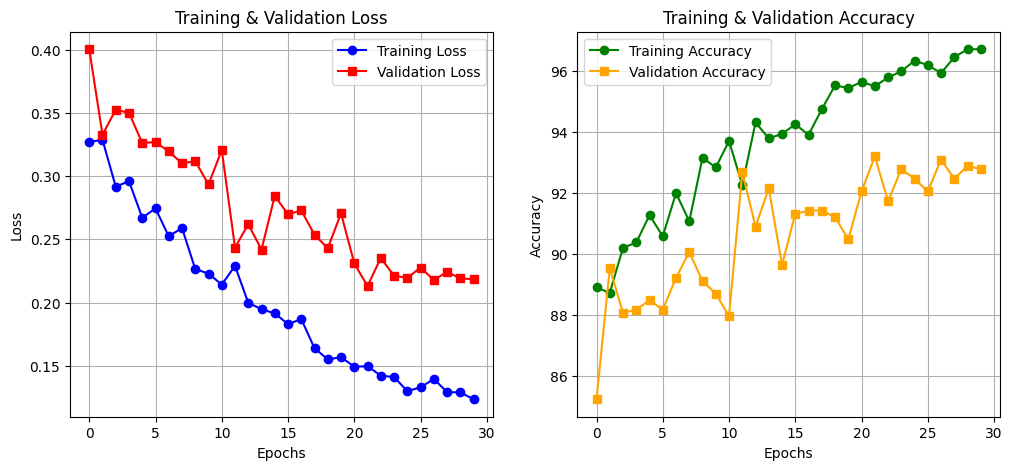


========== Evaluating Swin-tiny V2 on Validation Set ==========


Overall Accuracy: 92.78%
Overall Error Rate: 7.22%
F1-Score (Macro-Averaged): 92.89%
F1-Score (Weighted): 92.79%
Matthews Correlation Coefficient (MCC): 91.59%
Cohen’s Kappa Score: 91.56%
Top-1 Accuracy (%): 92.78%
Top-5 Accuracy (%): 99.79%

Average Inference Time per Image: 0.086440 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          87.08       94.51         90.64            97.10
 BRRI_28          98.29       89.84         93.88            99.76
 BRRI_29          90.70       86.03         88.30            98.54
 BRRI_34          90.54       96.40         93.38            98.29
 BRRI_50          94.26       94.26         94.26            99.16
 BRRI_74          94.29       96.35         95.31            99.02
    BR_5          97.54       91.54         94.44            99.64

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108 

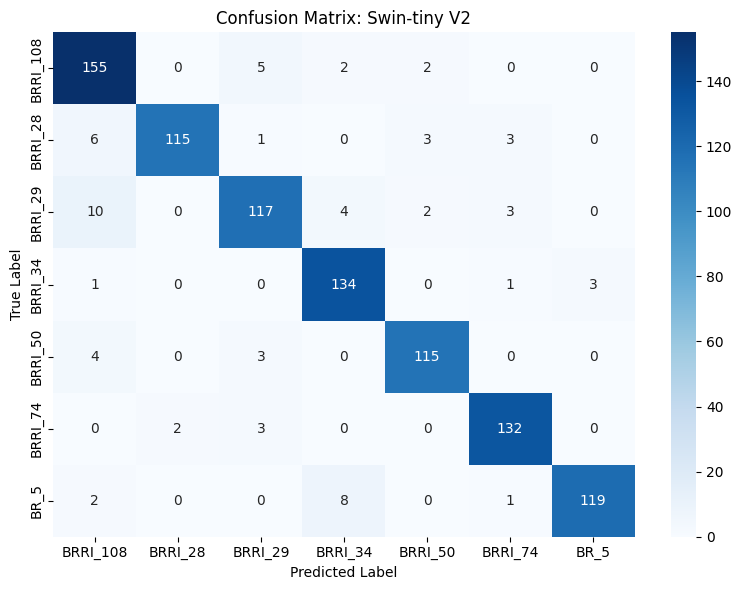

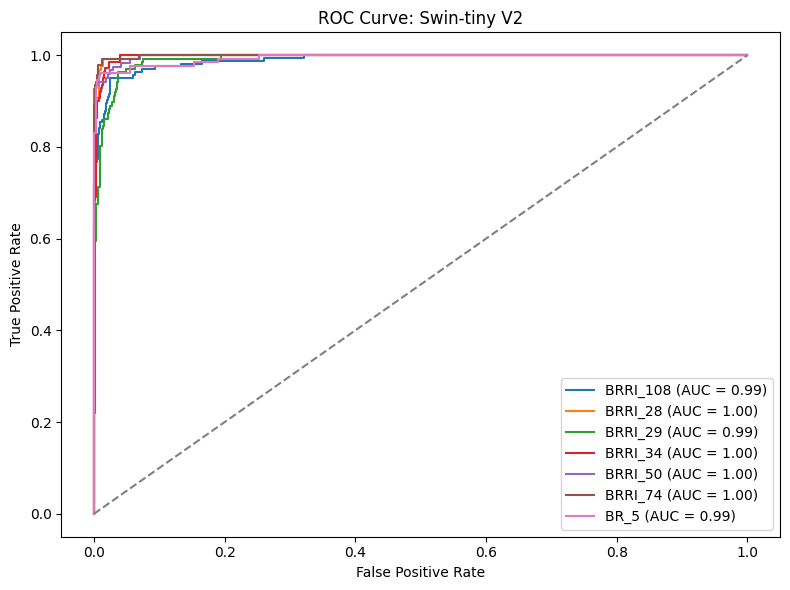

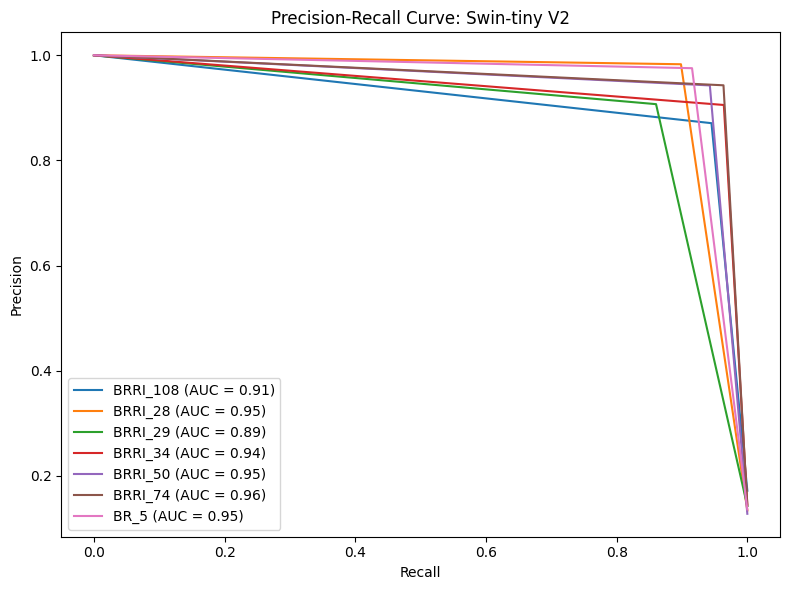


========== Evaluating Swin-tiny V2 on Tesing Set ==========


Overall Accuracy: 91.91%
Overall Error Rate: 8.09%
F1-Score (Macro-Averaged): 91.88%
F1-Score (Weighted): 91.94%
Matthews Correlation Coefficient (MCC): 90.57%
Cohen’s Kappa Score: 90.54%
Top-1 Accuracy (%): 91.91%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.086628 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          83.33       85.94         84.62            97.37
 BRRI_28          96.10       90.24         93.08            99.25
 BRRI_29          87.14       91.04         89.05            97.83
 BRRI_34          89.02       94.81         91.82            97.78
 BRRI_50          98.51       97.06         97.78            99.76
 BRRI_74          93.65       96.72         95.16            99.05
    BR_5          96.49       87.30         91.67            99.52

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108    

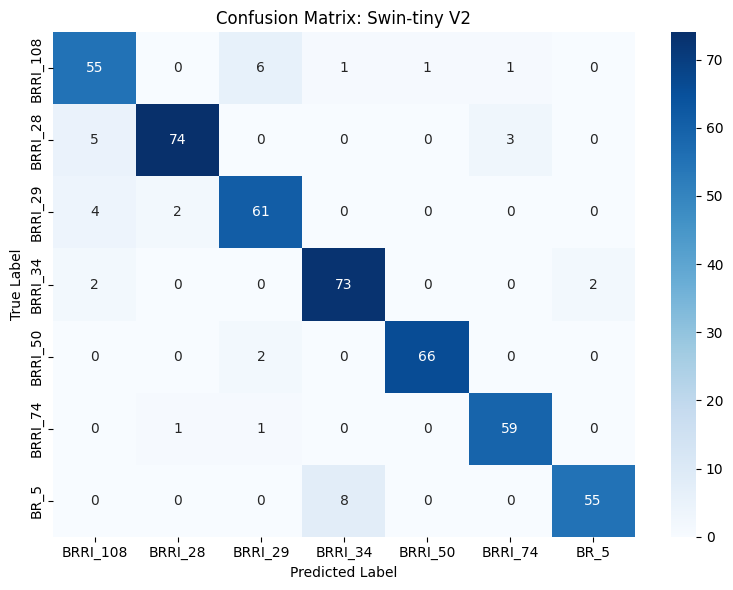

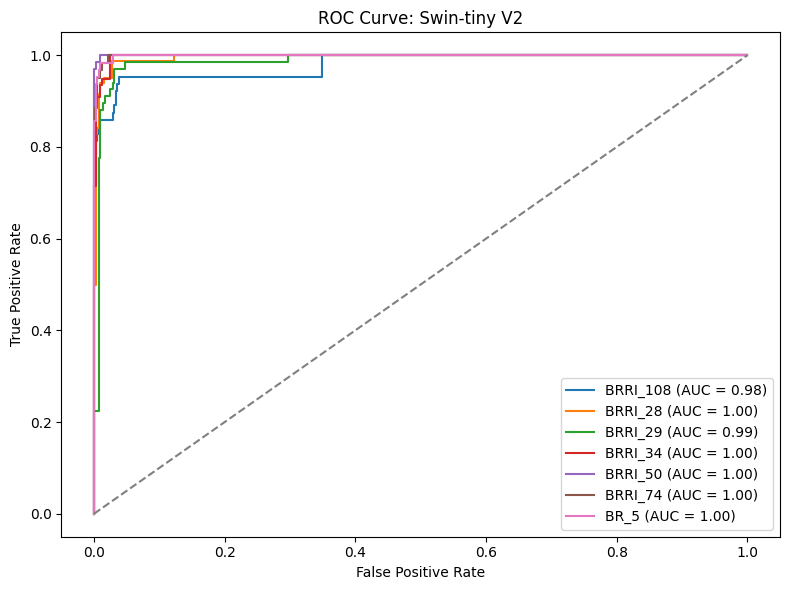

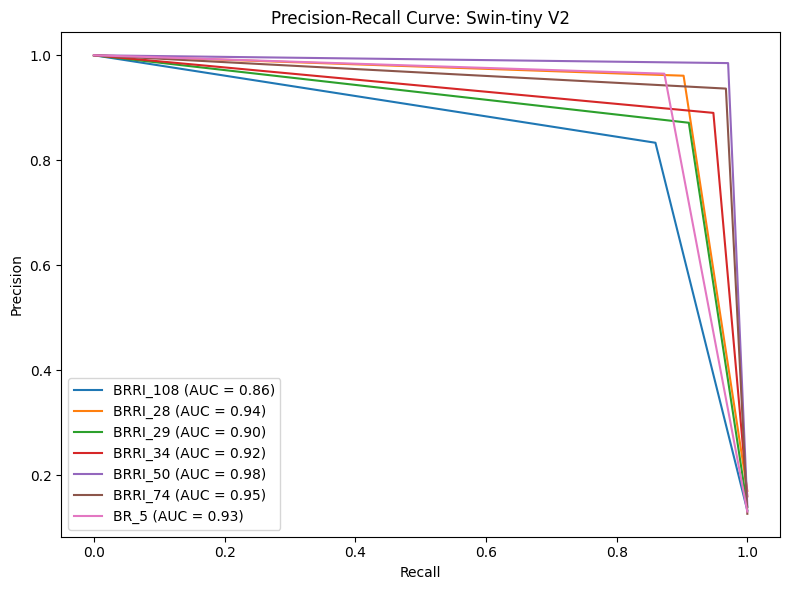

In [44]:
plotting(history2)
metrics = evaluate_model(model2, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="Swin-tiny V2")
metrics = evaluate_model(model2, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="Swin-tiny V2")